# Classification for place de marché : TransferLearning using VGG16 model

Now the feasability is established, we will continue to supervised classification

We will : 
- Split our data set
- Augment our data
- Train our model
- Predict our classes

In [4]:
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import shutil


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.model_selection import StratifiedShuffleSplit

# librairies for NLP
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras import metrics as kmetrics
from tensorflow.keras import layers,callbacks
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory,plot_model
from tensorflow.keras.applications.vgg16 import VGG16
import keras_tuner

# image imports
from matplotlib.image import imread
import PIL
from PIL import Image, ImageFilter, ImageEnhance

import cv2

In [6]:
# Using the dataset to prepare the subset "data_img"

data = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
data['general_category'] = data['product_category_tree'].map(lambda x: x.strip('["]').split(' >> ')[0])
data_img = pd.DataFrame()
data_img['image'] = data['image']
data_img['category'] = data['general_category']
data_img['img_path'] = [os.path.join('data/Images/', filename) for filename in data_img['image']]
data_img.head()

,image,category,img_path
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,data/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,data/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,data/Images/64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,data/Images/d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,data/Images/6325b6870c54cd47be6ebfbffa620ec7.jpg


We will split our data in train/test/val directories, and each of them will contain a directory according to the classes to be predicted

In [8]:
#Liste of categories
categories = data_img["category"].unique().tolist()

#Ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# images paths
image_dir = './data/Images/'

# supervised directory 
supervised_dir = './data/Images_supervised/'

# folders creation
for category in categories:
    os.makedirs(os.path.join(supervised_dir, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(supervised_dir, 'validation', category), exist_ok=True)
    os.makedirs(os.path.join(supervised_dir, 'test', category), exist_ok=True)

# paths to datasets
train_dir = f'{supervised_dir}train'
validation_dir = f'{supervised_dir}validation'
test_dir = f'{supervised_dir}test'

for category in categories:
    # filter image by category
    category_images = data_img[data_img['category'] == category]['image'].tolist()

    # Divide between train, validation, and test
    train_images, test_val_images = train_test_split(category_images, test_size=val_ratio + test_ratio, random_state=22)
    val_images, test_images = train_test_split(test_val_images, test_size=test_ratio / (val_ratio + test_ratio), random_state=22)

    # Move image to relevant folder
    for img in train_images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(supervised_dir, 'train', category, img)
        shutil.copy(src, dst)

    for img in val_images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(supervised_dir, 'validation', category, img)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(supervised_dir, 'test', category, img)
        shutil.copy(src, dst)

### Model Creation

Attention !\
 Don't use ImageDataGenerator instead of keras.Sequential : better readability, can go back to original image

In [55]:
#define a model
model_base=VGG16(weights="imagenet", 
                 input_shape=(224, 224, 3), 
                 include_top=False)

for layer in model_base.layers:
  layer.trainable = False
#model_base.trainable=False

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal",input_shape=(224, 224, 3)),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.5),
  ])


model = keras.Sequential([
    # Preprocessing
    data_augmentation,
    # Base
    model_base,
    # Head
    #layers.Flatten(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    #layers.Dropout(0.2),
    layers.Dense(7, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #1e-3
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)
model.build(input_shape=(None,224, 224, 3))
print(model.summary())

C:\Users\kanam\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [10]:
"""plot_model(model, 
show_shapes=True, 
show_layer_names=True,
show_layer_activations=True)"""

'plot_model(model, \nshow_shapes=True, \nshow_layer_names=True,\nshow_layer_activations=True)'

Séparation entre train et test

CF documentaion on image_dataset_from_directory

In [19]:
X_train = image_dataset_from_directory(
                    directory="data/Images_supervised/train/",
                    labels='inferred',
                    label_mode='categorical',
                    class_names=None,
                    batch_size=400,
                    image_size=(224, 224))

Found 735 files belonging to 7 classes.


In [21]:
X_test = image_dataset_from_directory(
                    directory="data/Images_supervised/test/",
                    labels='inferred',
                    label_mode='categorical',
                    class_names=None,
                    batch_size=400,
                    shuffle=False,
                    image_size=(224, 224))

Found 161 files belonging to 7 classes.


In [23]:
X_val = image_dataset_from_directory(
                    directory="data/Images_supervised/validation/",
                    labels='inferred',
                    label_mode='categorical',
                    class_names=None,
                    batch_size=400,
                    image_size=(224, 224))

Found 154 files belonging to 7 classes.


### Fit and predict

In [58]:
# define how long to wait before interruption
min_improvement = 0.001
epochs_to_wait = 10
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                       min_delta=min_improvement,
                                       patience=epochs_to_wait,
                                       restore_best_weights=True)

In [59]:
history = model.fit(X_train,
                  validation_data=X_val,
                  epochs=100,
                  verbose=1,
                  callbacks=[early_stopping])

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 49s 28s/step - accuracy: 0.1687 - loss: 8.1198 - val_accuracy: 0.2273 - val_loss: 7.3983
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 48s 26s/step - accuracy: 0.3225 - loss: 4.3845 - val_accuracy: 0.3701 - val_loss: 4.1281
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 26s/step - accuracy: 0.4828 - loss: 2.4523 - val_accuracy: 0.6169 - val_loss: 2.1293
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 26s/step - accuracy: 0.5998 - loss: 2.2120 - val_accuracy: 0.6364 - val_loss: 2.1113
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 28s/step - accuracy: 0.5861 - loss: 1.7686 - val_accuracy: 0.6753 - val_loss: 1.8811
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 25s/step - accuracy: 0.6898 - loss: 1.5892 - val_accuracy: 0.7208 - val_loss: 1.4352
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 25s/step - accuracy: 0.7252 - loss: 1.5872 - val_accuracy: 0.7468 - val_loss: 1.2724
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 25s/step - accuracy: 0.7594 - loss: 1.2117 - val_accuracy: 0.7597 - val_loss:

Several tests presented different results \
Somtimes the early stopping function stops at 25, sometimes 38, and sometimes not at all \
We will limit to 60 epochs, in order to search within our hypothetically ideal ground, which is from 25 to 50 epochs

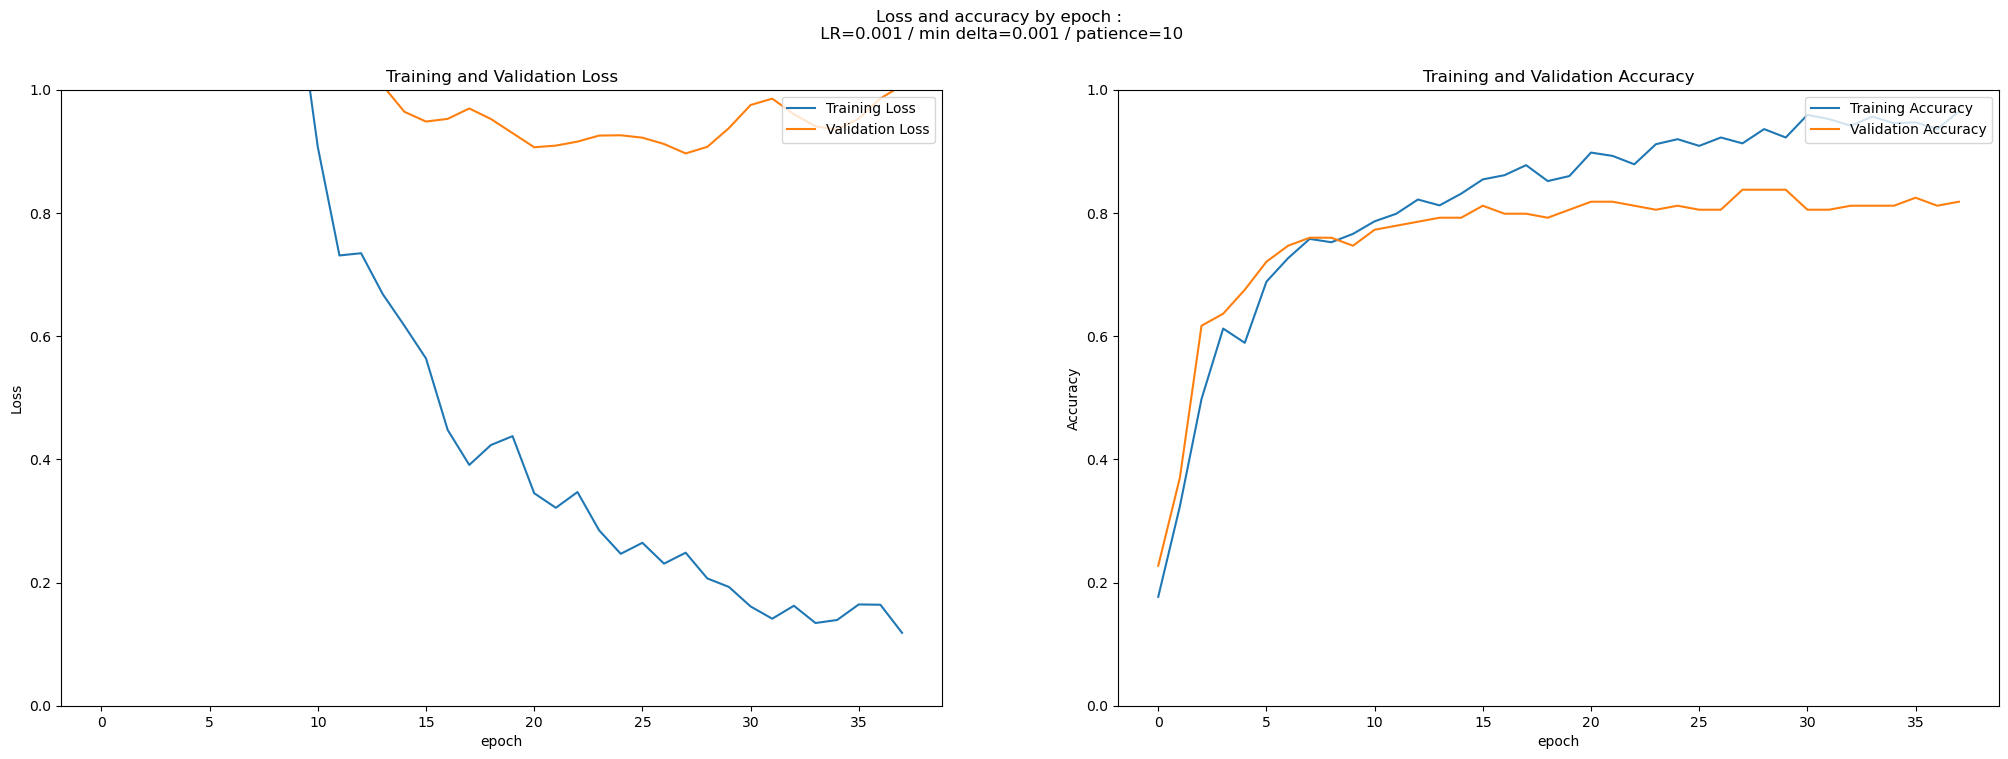

In [177]:
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

# plotting loss
ax[0].plot(history_frame['loss'], label='Training Loss')
ax[0].plot(history_frame['val_loss'], label='Validation Loss')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,1.0])
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('epoch')

# plotting accuracy
ax[1].plot(history_frame['accuracy'], label='Training Accuracy')
ax[1].plot(history_frame['val_accuracy'], label='Validation Accuracy')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim([0,1.0])
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('epoch')


plt.suptitle('Loss and accuracy by epoch :\n LR='+str(model.optimizer.learning_rate.numpy())+" / min delta="+str(min_improvement)+" / patience="+str(epochs_to_wait))
plt.show()

### Optimization

Will now try to opitmize batch and epochs hyperparameters 

Keras documentation warns us against using a batch parameter when using generated data https://keras.io/api/models/model_training_apis/ \
"batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.PyDataset instances (since they generate batches)."

Hence we only have to optimize our epochs. \
This is already done by using an EarlyStopping function, but we can observe the best epoch of current fit

In [153]:
# get the best # of epochs
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f"Best epoch : {best_epoch}")

Best epoch : 28


We can isolate the best epoch of this fit, which is within our predicted range \
We will recommend to settle for 40 epochs, in order to limit computationnal consumption but allow model to thrive \
We will keep the EarlyStopping function as good practice recommends it